## GPT/Claude based Schematic component recognition

[chain/start] [1:chain:RunnableSequence] Entering Chain run with input:
{
  "image_path": "simple_circuit.png",
  "prompt": "\n   Given the image which contains a circuit schematic drawing, provide the following information:\n   - A count of how many components are in the image\n   - A list of wires present on this schematic drawing, including start and end position on the image (you may approaximate using pixel locations)\n   - A list of components present on this schematic drawing, including their name (like 'resistor', 'capacitor' etc), position on the image, and orientation (you may approaximate using pixel locations)\n   Please just reply ONLY in JSON output and nothing else!\n   "
}
[chain/start] [1:chain:RunnableSequence > 2:chain:TransformChain] Entering Chain run with input:
{
  "image_path": "simple_circuit.png",
  "prompt": "\n   Given the image which contains a circuit schematic drawing, provide the following information:\n   - A count of how many components are in the imag
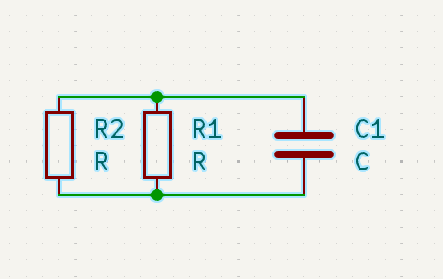

In [19]:
# python3 -m pip install langchain==0.0.351
# python3 -m pip install -U openai  (1.14.3)
import os
import langchain
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain.chains import TransformChain
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langchain import globals
from langchain_core.runnables import chain
import base64
from langchain_core.output_parsers import JsonOutputParser

API_KEY = 'key'

def load_image(inputs: dict) -> dict:
    """Load image from file and encode it as base64."""
    image_path = inputs["image_path"]
  
    def encode_image(image_path):
        with open(image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode('utf-8')
    image_base64 = encode_image(image_path)
    return {"image": image_base64}

    
load_image_chain = TransformChain(
    input_variables=["image_path"],
    output_variables=["image"],
    transform=load_image
)


# Define dictionary structure
from typing import TypedDict
class Wire(TypedDict):
    x: float
    y: float
    end_x: float
    end_y: float
# {"lib_id": "Switch:SW_DPST_x2", "x": 143.51, "y": 77.47, "angle":0, "reference_name": "SW1A"},
class Component(TypedDict):
    lib_id: str
    x: float
    y: float
    angle: float
    referenceOname: str
    

class ImageInformation(BaseModel):
    """Information about the image."""
    symbol_count: int = Field(description="number of circuit symbols in the image")
    detected_wires: list[Wire] = Field(description="list of dictionary containing beginning and end coordinates of the detected wire")
    detected_components: list[Component] = Field(description="list of dictionary containing the name,XY coordinates, angle and reference name for a detected circuit component")
    
# Set verbose
globals.set_debug(True)

@chain
def image_model(inputs: dict):# -> str | list[str] | dict:
    """Invoke model with image and prompt."""
    model = ChatOpenAI(openai_api_key=API_KEY, temperature=0.5, model="gpt-4-vision-preview", max_tokens=1024)
    msg = model.invoke(
        [HumanMessage(
            content=[
                {"type": "text", "text": inputs["prompt"]},
                {"type": "text", "text": parser.get_format_instructions()},
                {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{inputs['image']}"}},
                ]
            )]
        )
    return msg.content

parser = JsonOutputParser(pydantic_object=ImageInformation)

# including start and end position on the image (you may approaximate using pixel locations)
# including their name, position on the image, and orientation (you may approaximate using pixel locations)
# Can you recognize and list all the electronic components on this schematic drawing and generate an netlist-like list of this diagram?
def get_image_informations(image_path: str) -> dict:
   vision_prompt = """
   Given the image which contains a circuit schematic drawing, provide the following information:
   - A count of how many components are in the image
   - A list of wires present on this schematic drawing, including start and end position on the image (you may approaximate using pixel locations)
   - A list of components present on this schematic drawing, including their name (like 'resistor', 'capacitor' etc), position on the image, and orientation (you may approaximate using pixel locations)
   Please just reply ONLY in JSON output and nothing else!
   """
   
#    vision_prompt = """
#    Can you recognize and list all the electronic components on this schematic drawing and generate well formated JSON output?
#    Please just reply ONLY in JSON output and nothing else!
#    """
   vision_chain = load_image_chain | image_model | parser
   return vision_chain.invoke({'image_path': f'{image_path}', 
                               'prompt': vision_prompt})

result = get_image_informations("simple_circuit.png")
print(result)
print(type(result))

In [20]:
# iterate through the list of dicts results and remove empty dicts
for i in range(len(result['detected_components'])):
    if not result['detected_components'][i]:
        del result['detected_components'][i]

In [21]:
for component in result["detected_components"]:
    print(component["lib_id"])


resistor
resistor
capacitor


In [22]:
def match_libId(raw_libid:str):
    lib_id = raw_libid
    if "resistor" == raw_libid:
        lib_id = "Device:R"
    elif "capacitor" == raw_libid:
        lib_id = "Device:C"
    elif "transistor" == raw_libid:
        lib_id = "Device:R"
    elif "potentiometer" == raw_libid:
        lib_id = "Device:R"
    
    return lib_id


    
    


In [23]:
import kicad_utils
kicad_schematic_path = "testProject/testProject.kicad_sch"
list_of_component_dict =[]


for symbol in result["detected_components"]:
    print(symbol["lib_id"], symbol["x"], symbol["y"], symbol["angle"], symbol["referenceOname"])
    
    # Add the component to the list
    list_of_component_dict.append({"lib_id": match_libId(symbol["lib_id"]), "x": symbol["x"], "y": symbol["y"], "angle": symbol["angle"], "reference_name": symbol["referenceOname"]})


    

resistor 75 140 90 R2
resistor 125 140 90 R1
capacitor 225 140 0 C1


In [24]:
kicad_utils.modify_kicad_sch_file(components = list_of_component_dict, file_path=kicad_schematic_path)

Reading file /usr/share/kicad/symbols/Device.kicad_sym
Reading file /usr/share/kicad/symbols/Device.kicad_sym
Reading file /usr/share/kicad/symbols/Device.kicad_sym
Modified file testProject/testProject.kicad_sch


'(kicad_sch\n\t(version 20231120)\n\t(generator "eeschema")\n\t(generator_version "8.0")\n\t(uuid "59526c9f-d2d4-4c47-ba25-9347dc717d36")\n\t(paper "A4")\n\t(lib_symbols\n (symbol "Device:C"\n\t\t(pin_numbers hide)\n\t\t(pin_names\n\t\t\t(offset 0.254)\n\t\t)\n\t\t(exclude_from_sim no)\n\t\t(in_bom yes)\n\t\t(on_board yes)\n\t\t(property "Reference" "C"\n\t\t\t(at 0.635 2.54 0)\n\t\t\t(effects\n\t\t\t\t(font\n\t\t\t\t\t(size 1.27 1.27)\n\t\t\t\t)\n\t\t\t\t(justify left)\n\t\t\t)\n\t\t)\n\t\t(property "Value" "C"\n\t\t\t(at 0.635 -2.54 0)\n\t\t\t(effects\n\t\t\t\t(font\n\t\t\t\t\t(size 1.27 1.27)\n\t\t\t\t)\n\t\t\t\t(justify left)\n\t\t\t)\n\t\t)\n\t\t(property "Footprint" ""\n\t\t\t(at 0.9652 -3.81 0)\n\t\t\t(effects\n\t\t\t\t(font\n\t\t\t\t\t(size 1.27 1.27)\n\t\t\t\t)\n\t\t\t\t(hide yes)\n\t\t\t)\n\t\t)\n\t\t(property "Datasheet" "~"\n\t\t\t(at 0 0 0)\n\t\t\t(effects\n\t\t\t\t(font\n\t\t\t\t\t(size 1.27 1.27)\n\t\t\t\t)\n\t\t\t\t(hide yes)\n\t\t\t)\n\t\t)\n\t\t(property "Description"

In [27]:
result['detected_wires']

[{'x': 50, 'y': 140, 'end_x': 100, 'end_y': 140},
 {'x': 100, 'y': 140, 'end_x': 150, 'end_y': 140},
 {'x': 150, 'y': 140, 'end_x': 200, 'end_y': 140},
 {'x': 200, 'y': 140, 'end_x': 250, 'end_y': 140}]

In [28]:
kicad_utils.create_kicad_sch_file(components = list_of_component_dict, wires=result['detected_wires'])

Reading file /usr/share/kicad/symbols/Device.kicad_sym
Reading file /usr/share/kicad/symbols/Device.kicad_sym
Reading file /usr/share/kicad/symbols/Device.kicad_sym
Created file temp_8d83320d-750b-4c0f-8f73-947cf04aeb55.kicad_sch


'(kicad_sch\n    (version 20231120)\n    (generator "SidYifanOmarNeel")\n    (generator_version "8.0")\n    (uuid "63fed043-2de3-4d9e-b607-289de34766df")\n    (paper "A4")\n    (lib_symbols\n (symbol "Device:C"\n\t\t(pin_numbers hide)\n\t\t(pin_names\n\t\t\t(offset 0.254)\n\t\t)\n\t\t(exclude_from_sim no)\n\t\t(in_bom yes)\n\t\t(on_board yes)\n\t\t(property "Reference" "C"\n\t\t\t(at 0.635 2.54 0)\n\t\t\t(effects\n\t\t\t\t(font\n\t\t\t\t\t(size 1.27 1.27)\n\t\t\t\t)\n\t\t\t\t(justify left)\n\t\t\t)\n\t\t)\n\t\t(property "Value" "C"\n\t\t\t(at 0.635 -2.54 0)\n\t\t\t(effects\n\t\t\t\t(font\n\t\t\t\t\t(size 1.27 1.27)\n\t\t\t\t)\n\t\t\t\t(justify left)\n\t\t\t)\n\t\t)\n\t\t(property "Footprint" ""\n\t\t\t(at 0.9652 -3.81 0)\n\t\t\t(effects\n\t\t\t\t(font\n\t\t\t\t\t(size 1.27 1.27)\n\t\t\t\t)\n\t\t\t\t(hide yes)\n\t\t\t)\n\t\t)\n\t\t(property "Datasheet" "~"\n\t\t\t(at 0 0 0)\n\t\t\t(effects\n\t\t\t\t(font\n\t\t\t\t\t(size 1.27 1.27)\n\t\t\t\t)\n\t\t\t\t(hide yes)\n\t\t\t)\n\t\t)\n\t\t(pr

In [18]:
import kicad_utils
temp_file_path = "testProject/testProject.kicad_sch"

temp_components = [
    # {"lib_id": ":SW_DPST_x2", "x": 143.51, "y": 77.47, "angle":0, "reference_name": "SW1A"},
    # {"lib_id": "Device:Ammeter_AC", "x": 133.35, "y": 64.77, "angle":0, "reference_name": "BT1"},
    # {"lib_id": "Device:Ammeter_AC", "x": 133.35, "y": 64.77, "angle":0, "reference_name": "BT1"},
    {"lib_id": "Device:R", "x": 146.05, "y": 53.34, "angle":90, "reference_name": "R1"}
]

# kicad_utils.extract_symbol_definition("Device:R")
# kicad_utils.modify_kicad_sch_file(components = temp_components, file_path=temp_file_path)
kicad_utils.create_kicad_sch_file(components = temp_components,)


Reading file /usr/share/kicad/symbols/Device.kicad_sym
Modified file testProject/testProject.kicad_sch


'(kicad_sch\n\t(version 20231120)\n\t(generator "eeschema")\n\t(generator_version "8.0")\n\t(uuid "59526c9f-d2d4-4c47-ba25-9347dc717d36")\n\t(paper "A4")\n\t(lib_symbols\n (symbol "Device:R"\n\t\t(pin_numbers hide)\n\t\t(pin_names\n\t\t\t(offset 0)\n\t\t)\n\t\t(exclude_from_sim no)\n\t\t(in_bom yes)\n\t\t(on_board yes)\n\t\t(property "Reference" "R"\n\t\t\t(at 2.032 0 90)\n\t\t\t(effects\n\t\t\t\t(font\n\t\t\t\t\t(size 1.27 1.27)\n\t\t\t\t)\n\t\t\t)\n\t\t)\n\t\t(property "Value" "R"\n\t\t\t(at 0 0 90)\n\t\t\t(effects\n\t\t\t\t(font\n\t\t\t\t\t(size 1.27 1.27)\n\t\t\t\t)\n\t\t\t)\n\t\t)\n\t\t(property "Footprint" ""\n\t\t\t(at -1.778 0 90)\n\t\t\t(effects\n\t\t\t\t(font\n\t\t\t\t\t(size 1.27 1.27)\n\t\t\t\t)\n\t\t\t\t(hide yes)\n\t\t\t)\n\t\t)\n\t\t(property "Datasheet" "~"\n\t\t\t(at 0 0 0)\n\t\t\t(effects\n\t\t\t\t(font\n\t\t\t\t\t(size 1.27 1.27)\n\t\t\t\t)\n\t\t\t\t(hide yes)\n\t\t\t)\n\t\t)\n\t\t(property "Description" "Resistor"\n\t\t\t(at 0 0 0)\n\t\t\t(effects\n\t\t\t\t(font\n\t

## Try adding wires


In [26]:
import skip


# load a schematic
schem = skip.Schematic("testProject/testProject.kicad_sch")
a_wire = schem.wire.new()
a_wire.start.value = (0,0)
a_wire.end.value = (100,100)

# save the schematic
schem.write("testProject/testProject.kicad_sch")

In [ ]:
# print(schem.symbol.R1.location)
for component in schem.symbol:
    # print(component.pin[0].location)
    print(component.lib_id)

    # print(type(component))

<AtValue (142.24, 53.34, 180)>
<AtValue (160.02, 66.04, 90)>


Note: you may need to restart the kernel to use updated packages.
